# Contrarian Trading Strategy

https://www.quantifiedstrategies.com/contrarian-trading-strategy/

In [1]:
import datetime as dt
import pandas as pd
import yfinance as yf

C:\Users\tomw1\AppData\Local\Temp\ipykernel_14576\4020808254.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

def calculate_rsi(close_px: pd.Series | pd.DataFrame, window: int = 3) -> pd.Series:

    # Calculate price changes
    delta = close_px.diff()

    # Calculate gains and losses
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)

    # Calculate average gains and losses over a 2-day window
    avg_gains = gains.rolling(window=window, min_periods=1).mean()
    avg_losses = losses.rolling(window=window, min_periods=1).mean()

    # Calculate relative strength (RS)
    rs = avg_gains / avg_losses

    # Calculate the Relative Strength Index (RSI) for a 2-day period
    rsi_xday = 100 - (100 / (1 + rs))

    return rsi_xday


## Rules

1. When x-day RSI indicator falls below 20, buy at the close.
2. When the close is higher than yesterday's close, exit position.

In [3]:
XDAY = 2
START = dt.date(2020, 1, 1)
END = dt.date.today()

In [4]:
TICKER = "SPY"

In [5]:
data = yf.download(TICKER, progress=False)["Close"].to_frame(name=TICKER)
data.head(5)

C:\Users\tomw1\AppData\Local\pypoetry\Cache\virtualenvs\quantified-strategies-wFBlb7GR-py3.11\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,SPY
Date,
1993-01-29,43.93750
1993-02-01,44.25000
1993-02-02,44.34375
1993-02-03,44.81250
1993-02-04,45.00000


In [6]:
data = data.loc[(data.index.date >= START) & (data.index.date <= END)]
data.head(5)

,SPY
Date,
2020-01-02,324.869995
2020-01-03,322.410004
2020-01-06,323.640015
2020-01-07,322.730011
2020-01-08,324.450012


In [7]:
data[f"{TICKER}_ret"] = data[TICKER].pct_change()
data[f"{TICKER}_ret_shifted"] = data[f"{TICKER}_ret"].shift(-1)
data.head(5)

,SPY,SPY_ret,SPY_ret_shifted
Date,,,
2020-01-02,324.869995,NaN,-0.007572
2020-01-03,322.410004,-0.007572,0.003815
2020-01-06,323.640015,0.003815,-0.002812
2020-01-07,322.730011,-0.002812,0.005330
2020-01-08,324.450012,0.005330,0.006781


In [8]:
data["rsi"] = calculate_rsi(close_px=data[TICKER], window=XDAY)
data.head(5)

,SPY,SPY_ret,SPY_ret_shifted,rsi
Date,,,,
2020-01-02,324.869995,NaN,-0.007572,NaN
2020-01-03,322.410004,-0.007572,0.003815,0.000000
2020-01-06,323.640015,0.003815,-0.002812,33.333609
2020-01-07,322.730011,-0.002812,0.005330,57.476755
2020-01-08,324.450012,0.005330,0.006781,65.399165


In [9]:
data["entry_flag"] = data["rsi"] < 20
data["exit_flag"] = data[TICKER] > data[TICKER].shift(1)
data.head(5)

,SPY,SPY_ret,SPY_ret_shifted,rsi,entry_flag,exit_flag
Date,,,,,,
2020-01-02,324.869995,NaN,-0.007572,NaN,False,False
2020-01-03,322.410004,-0.007572,0.003815,0.000000,True,False
2020-01-06,323.640015,0.003815,-0.002812,33.333609,False,True
2020-01-07,322.730011,-0.002812,0.005330,57.476755,False,False
2020-01-08,324.450012,0.005330,0.006781,65.399165,False,True


In [10]:
# Get Position
def get_position(row: pd.Series, last_position: int) -> int:
    if row["entry_flag"]:
        return 1
    if last_position == 0:
        return 0
    if row["exit_flag"]:
        return 0
    return last_position

positions = dict()
pos = 0
for date, row in data.iterrows():
    pos = get_position(row=row, last_position=pos)
    positions[date] = pos

data["pos"] = pd.Series(positions, dtype=int)
data.dropna().head(5)

,SPY,SPY_ret,SPY_ret_shifted,rsi,entry_flag,exit_flag,pos
Date,,,,,,,
2020-01-03,322.410004,-0.007572,0.003815,0.000000,True,False,1
2020-01-06,323.640015,0.003815,-0.002812,33.333609,False,True,0
2020-01-07,322.730011,-0.002812,0.005330,57.476755,False,False,0
2020-01-08,324.450012,0.005330,0.006781,65.399165,False,True,0
2020-01-09,326.649994,0.006781,-0.002878,100.000000,False,True,0


In [11]:
data["strat_ret"] = data[f"{TICKER}_ret_shifted"] * data["pos"]
data["adj_strat_ret"] = data["strat_ret"] / data["pos"].expanding(min_periods=10).mean().fillna(1.0)

In [12]:
data["cum_strat_ret"] = (1 + data["strat_ret"]).cumprod() - 1
data["cum_adj_strat_ret"] = (1 + data["adj_strat_ret"]).cumprod() - 1
data["cum_hodl_ret"] = (1 + data[f"{TICKER}_ret_shifted"]).cumprod() - 1

In [13]:
import matplotlib.pyplot as plt

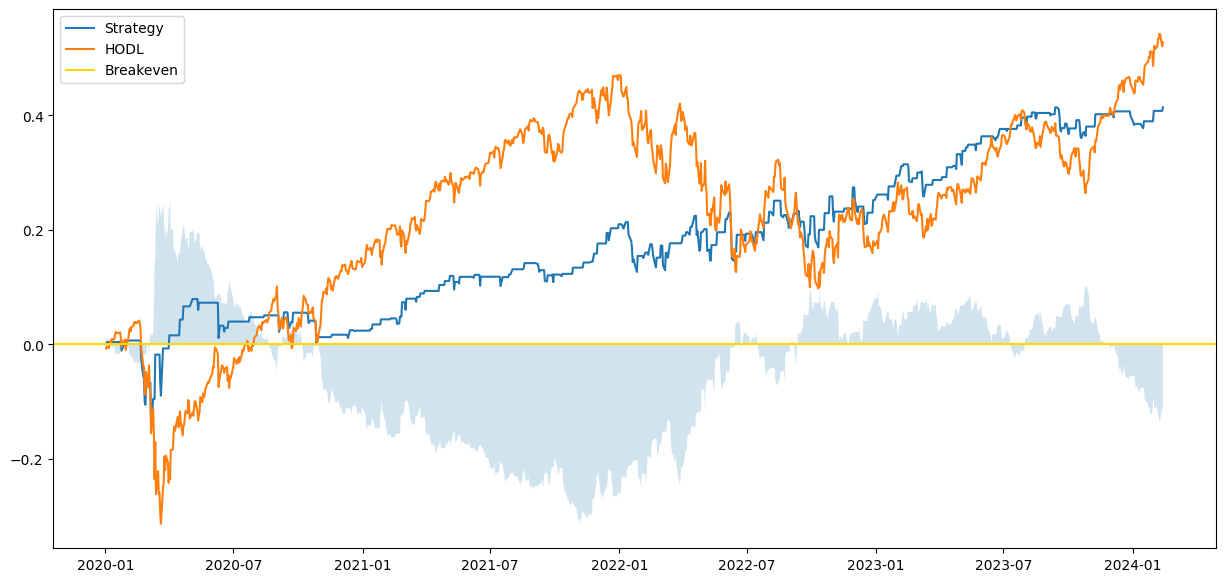

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(data["cum_strat_ret"], label="Strategy")
ax.plot(data["cum_hodl_ret"], label="HODL")
ax.axhline(y=0, label="Breakeven", color="gold")
ax.fill_between(data.index.tolist(), data["cum_strat_ret"] - data["cum_hodl_ret"], alpha=0.2)

plt.legend(loc="best")
plt.show()


In [19]:
data["strat_ret"].loc[data["pos"] != 0.0].mean() * 10_000

13.37905085281012

In [21]:
data[f"{TICKER}_ret_shifted"].mean() * 10_000

5.09534616682685

In [ ]:
(1 + data[f"{TICKER}_ret_shifted"].mean()) ** 3 = 1 + data["strat_ret"].loc[data["pos"] != 0.0].mean()

In [22]:
import numpy as np

In [23]:
np.log(1 + data["strat_ret"].loc[data["pos"] != 0.0].mean()) / np.log(1 + data[f"{TICKER}_ret_shifted"].mean())

2.624652853231767